In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import glob
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
#from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Creamos el dataframe y lo rellenamos con las imágenes y las etiquetas para cada una de ellas.

In [2]:
df = pd.DataFrame()
# Conectamos con drive.google
from google.colab import drive
drive.mount('/content/drive/')

# Creamos las columnas
df['imagen']=None
df['data']=None
df['imagenvec']=None
df['nombreImagen']=None
df['target']=None
df['targetNum']=None

images = []

for filepath in glob.iglob('/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/*.*'):
  src = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
  src_gray = plt.imread(filepath)
  data=src_gray.flatten()
  if (filepath[-7]=='1'):
    target='cochlicella acuta'
    target_num=0
  if (filepath[-7]=='2'):
    target='Ferussacia folliculus'
    target_num=1
  if (filepath[-7]=='3'):
    target='Otala latea'
    target_num=2
  print(filepath + " " + target)
  images.append(src_gray)
  fila = {'imagenvec': np.array(data, dtype=np.uint8), 'imagen': src, 'nombreImagen': filepath, 'target':target, 'targetNum':target_num}
  df = df.append(fila, ignore_index=True)

df.data=df.imagenvec.array
X = np.array(images, dtype=np.uint8)
nClasses=3

Mounted at /content/drive/
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1a.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1b.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1c.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1d.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1e.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1f.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1g.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/1h.JPEG cochlicella acuta
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/2a.JPEG Ferussacia folliculus
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/2b.JPEG Ferussacia folliculus
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/2c.JPEG Ferussacia folliculus
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/2d.JPEG Ferussacia folliculus
/content/drive/MyDrive/TFM-IA/snail-spicie/SVM/2e.JPEG Ferussacia folliculus
/con

## separamos en training y test

In [3]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, df.target, test_size=0.3333, random_state=0)

#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X, df.targetNum,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (28, 256, 416, 3) (28,)
Testing data shape :  (8, 256, 416, 3) (8,)
Original label: 0
After conversion to one-hot: [0. 0. 1.]
(22, 256, 416, 3) (6, 256, 416, 3) (22, 3) (6, 3)


## Preparamos el modelo

In [33]:

INIT_LR = 1e-3
dropout=0.5
#dropout=0.7
batch_size = 10
 
model = Sequential()
model.add(Conv2D(100, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(256,416,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(32, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(dropout)) 
model.add(Dense(nClasses, activation='softmax'))

## Entrenamos el modelo

In [34]:
model.summary()
 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 416, 100)     2800      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256, 416, 100)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 208, 100)    0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128, 208, 100)     0         
                                                                 
 flatten_3 (Flatten)         (None, 2662400)           0         
                                                                 
 dense_6 (Dense)             (None, 32)                85196832  
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [35]:
epochs=10
train_dropout = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
#train_dropout = model.fit(train_X, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
model.save("snail_model.h5py")

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 5.1686 - accuracy: 0.3182 - val_loss: 14.5518 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 10.5379 - accuracy: 0.2273 - val_loss: 2.2860 - val_accuracy: 0.3333
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 1.5920 - accuracy: 0.5000 - val_loss: 1.0697 - val_accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 1.2947 - accuracy: 0.5000 - val_loss: 1.0659 - val_accuracy: 0.3333
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 1.5160 - accuracy: 0.5000 - val_loss: 1.0999 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 1.1026 - accuracy: 0.4545 - val_loss: 1.0745 - val_accuracy: 0.3333
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 2.3414 - accuracy: 0.2727 - val_loss: 1.1669 - val_accuracy: 0.3333
Epoch 8/10
3/3 [=======================

In [ ]:

test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

1/1 [==============================] - 0s 212ms/step - loss: 1.1777 - accuracy: 0.2500
Test loss: 1.1777067184448242
Test accuracy: 0.25


In [36]:
x=[0,1,2,3,4,5,6,7,8,9,]
loss_1=[5.1686 ,10.5379 ,1.5920,1.2947 ,1.5160 ,1.1026 , 2.3414 ,1.2170 ,0.9501 ,0.7569  ]
accuracy_1=[0.3182, 0.2273 ,0.5000 ,0.5000 ,0.5000 , 0.4545,0.2727 ,0.2727 ,0.5455 ,0.6818 ]
val_loss_1=[14.5518, 2.2860, 1.0697 ,1.0659 ,1.0999 ,1.0745 ,1.1669 ,1.0392 ,1.1203 ,0.9711 ]
val_acc_1=[0.3333, 0.3333,0.3333,0.3333,0.5000, 0.3333,0.3333,0.5000,0.5000,0.5000]

loss_2=[5.6872 ,2.1333 ,1.8747 ,2.8257 ,2.0665 ,1.4548 ,1.3504 ,1.4385 ,2.1295 ,1.7584 ]
accuracy_2=[0.3182 ,0.5455  ,0.5000  ,0.4545  ,0.4091  , 0.4091 , 0.5455 , 0.4091  ,0.4545  ,0.3636]
val_loss_2=[28.3846 ,12.9694  ,1.8511  , 1.0126 , 1.3965 , 1.3742 ,1.2042  ,1.1549  ,1.1111  ,0.9746 ]
val_acc_2=[ 0.3333, 0.3333,  0.5000, 0.5000 ,0.3333 ,0.3333 ,0.5000 , 0.3333, 0.3333, 0.5000]

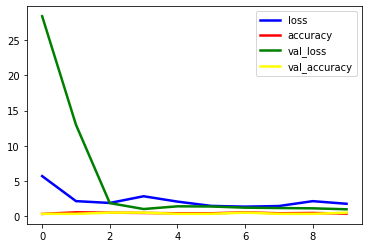

In [32]:
# importar todas las funciones de pylab
from pylab import *

# importar el módulo pyplot
import matplotlib.pyplot as pl



pl.plot(x, loss_2,color="blue", linewidth=2.5, linestyle="-", label="loss")
pl.plot(x, accuracy_2,color="red", linewidth=2.5, linestyle="-", label="accuracy")
pl.plot(x, val_loss_2,color="green", linewidth=2.5, linestyle="-", label="val_loss")
pl.plot(x, val_acc_2,color="yellow", linewidth=2.5, linestyle="-", label="val_accuracy")
pl.legend(loc='upper right')
pl.show()

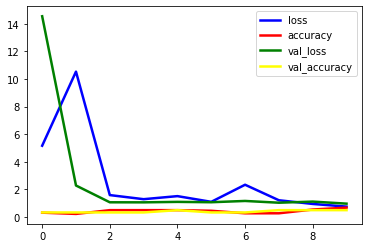

In [37]:
pl.plot(x, loss_1,color="blue", linewidth=2.5, linestyle="-", label="loss")
pl.plot(x, accuracy_1,color="red", linewidth=2.5, linestyle="-", label="accuracy")
pl.plot(x, val_loss_1,color="green", linewidth=2.5, linestyle="-", label="val_loss")
pl.plot(x, val_acc_1,color="yellow", linewidth=2.5, linestyle="-", label="val_accuracy")
pl.legend(loc='upper right')
pl.show()

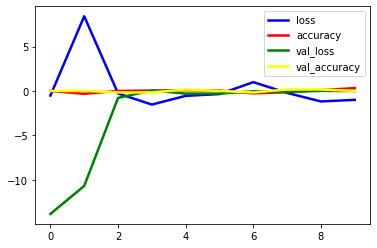

In [41]:
pl.plot(x, np.array(loss_1) - np.array(loss_2),color="blue", linewidth=2.5, linestyle="-", label="loss")
pl.plot(x, np.array(accuracy_1) - np.array(accuracy_2),color="red", linewidth=2.5, linestyle="-", label="accuracy")
pl.plot(x, np.array(val_loss_1) - np.array(val_loss_2),color="green", linewidth=2.5, linestyle="-", label="val_loss")
pl.plot(x, np.array(val_acc_1) - np.array(val_acc_2),color="yellow", linewidth=2.5, linestyle="-", label="val_accuracy")
pl.legend(loc='upper right')
pl.show()